In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
#GPU確認・設定
print(torch.cuda.get_device_name(0))
torch.cuda.is_available()
dev = torch.device = ("cuda:0")
print(dev)

NVIDIA A100-SXM4-80GB MIG 1g.10gb
cuda:0


In [3]:
#HPパラメータ
learning_rate = 0.001
batch_size = 100
epochs = 50
#結果保存用
history = {
    'train_loss' :[],
    'test_loss':[],
    'test_acc':[]
}

In [4]:
#MNISTデータセットの取得
# 学習用
train_dataset = datasets.MNIST(
    './data',               
    train = True,           
    download = True,      
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
)
# 評価用
test_dataset = datasets.MNIST(
    './data', 
    train = False,
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
)

In [5]:
#モデル定義
class MyFirstNet(nn.Module):
    def __init__(self):
        super(MyFirstNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=4,stride=2), #(13)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),#(6)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=2,stride=2),#(5)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,10,kernel_size=1),#(3)
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(64,10)
        self.gap = nn.AdaptiveAvgPool2d(1)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        x = self.flatten(x)
        #x = self.fc1(x)
        return x


In [6]:
#モデル生成・データロード
from torchsummary import summary
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
model = MyFirstNet()

In [7]:
print(model)

MyFirstNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
    (10): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gap): AdaptiveAvgPool2d(output_size=1)
)


In [8]:
#損失関数，最適化手法
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, foreach=None, maximize=False, differentiable=False)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
#学習ループ
def train_loop(dataloader,model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    sum_loss, avg_loss = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        sum_loss += loss.item()

        # 逆伝播
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    avg_loss = sum_loss / num_batches
    history['train_loss'].append(avg_loss)

In [10]:
#評価ループ
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / size)

In [11]:
#学習・評価
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293415  [  100/60000]
loss: 1.171891  [10100/60000]
loss: 1.028122  [20100/60000]
loss: 0.866189  [30100/60000]
loss: 0.639009  [40100/60000]
loss: 0.569478  [50100/60000]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.559039 

Epoch 2
-------------------------------
loss: 0.512043  [  100/60000]
loss: 0.485334  [10100/60000]
loss: 0.510382  [20100/60000]
loss: 0.438814  [30100/60000]
loss: 0.325130  [40100/60000]
loss: 0.311709  [50100/60000]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.335253 

Epoch 3
-------------------------------
loss: 0.319319  [  100/60000]
loss: 0.295558  [10100/60000]
loss: 0.328930  [20100/60000]
loss: 0.283275  [30100/60000]
loss: 0.196830  [40100/60000]
loss: 0.201073  [50100/60000]
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.232621 

Epoch 4
-------------------------------
loss: 0.224514  [  100/60000]
loss: 0.210536  [10100/60000]
loss: 0.235235  [20100/60000]
loss: 0.202170  [30100/60000]
loss: 0.133663  [40100/6

{'train_loss': [0.9085071746011575, 0.4181255921473106, 0.26755575329065323, 0.1914347820604841, 0.1457726054576536, 0.11531543023884297, 0.09314299848861993, 0.07597128573184211, 0.06278463233417521, 0.051933599148566524, 0.042880141260878496, 0.03543893699844678, 0.029022507624079784, 0.023540133646844576, 0.01899894282842676, 0.015401506908237933, 0.012330167632511196, 0.009800470909685827, 0.007960450756557597, 0.006538363288079078, 0.005291471745100959, 0.0043125973763138365, 0.0034882186621932004, 0.0029034502894501203, 0.002547488428002301, 0.026735117297697193, 0.008629458652915976, 0.0032967329439513074, 0.0019900845117323722, 0.0014826660811619755, 0.0012123870938497323, 0.0010242681417488104, 0.0008788000446293153, 0.0007559141624127126, 0.0006592261450593166, 0.0005700332253096956, 0.014903604224406687, 0.015460083711514017, 0.003279146377996464, 0.001365167033970162, 0.0008700715196876748, 0.0006817388343915809, 0.0005605584824115795, 0.0004707250745438311, 0.0004002497545

Text(0.5, 0, 'epoch')

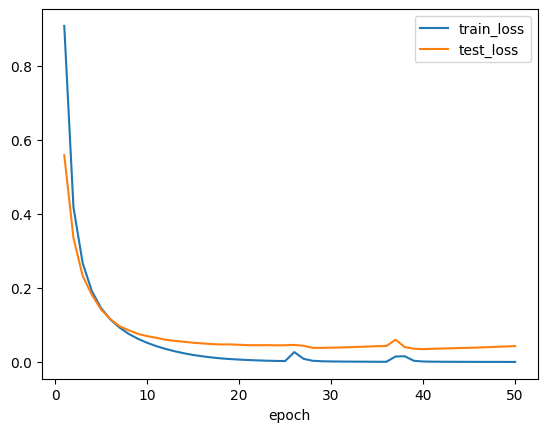

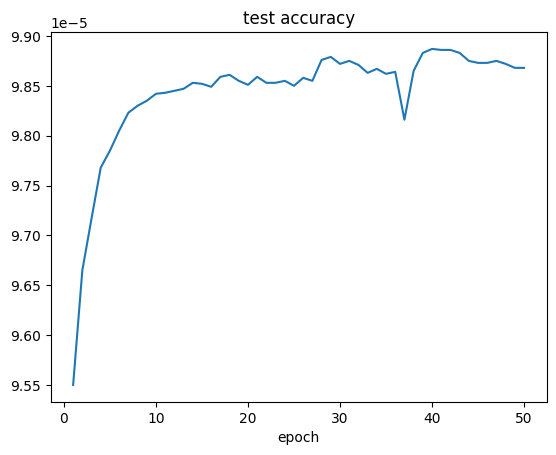

In [12]:
print(history)
plt.plot(range(1, epochs+1), history['train_loss'], label='train_loss')
plt.plot(range(1, epochs+1), history['test_loss'], label='test_loss')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
plt.plot(range(1, epochs+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')